In [1]:
import scipy.io as sio
from scipy.stats import mode
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

np.random.seed(42)

mat_content = sio.loadmat('assets/face.mat')
mat_content # Let's see the content...

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Sat May 27 02:07:24 2006',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[106, 130, 191, ...,  70, 183,  77],
        [103, 129, 185, ...,  62, 250,  72],
        [103, 130, 174, ...,  83, 163,  68],
        ...,
        [ 37,  40,  22, ...,  87, 102,  93],
        [ 36,  36,  19, ...,  89,  95, 103],
        [ 41,  35,  17, ...,  94, 106, 110]], dtype=uint8),
 'l': array([[ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,
          2,  2,  2,  2,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  4,  4,
          4,  4,  4,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,
          5,  5,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
          7,  7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
          9,  9,  9,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10, 10,
         10, 10, 10, 10, 11, 11, 11, 11, 11, 11, 11, 11, 11, 11, 12, 12,
         12, 12, 12, 12, 12, 12, 12, 12, 13,

In [2]:
# train, test data split

face_data = mat_content['X']
face_labels = mat_content['l']

x_train = []
x_test = []

y_train = []
y_test = []

n_classes = 52
images_per_class = 10

for i in range(n_classes):
    start_idx = i * images_per_class
    end_idx = start_idx + images_per_class
    
    x_train.append(face_data[:, start_idx:start_idx+8])
    x_test.append(face_data[:, start_idx+8:end_idx])

    y_train.append(face_labels[:, start_idx:start_idx+8])
    y_test.append(face_labels[:, start_idx+8:end_idx])

x_train = np.hstack(x_train)
x_test = np.hstack(x_test)
y_train = np.hstack(y_train)
y_test = np.hstack(y_test)



# Output the shapes of the training and testing sets
print(f"Training set shape: {x_train.shape}")
print(f"Test set shape: {x_test.shape}")

Training set shape: (2576, 416)
Test set shape: (2576, 104)


In [3]:
x_train = x_train.astype(np.float64)
x_test = x_test.astype(np.float64)

**PCA-LDA**

In [4]:
# 클래스별로 x_train을 쪼개는 함수

def split_by_class(x_train, y_train):
    y_train = y_train.flatten()
    classes = np.unique(y_train)  # 고유 클래스 값들
    class_dict = {}
    
    for cls in classes:
        # 해당 클래스에 해당하는 인덱스 필터링
        indices = np.where(y_train == cls)[0]
        # 클래스별 x_train 데이터를 딕셔너리에 저장
        class_dict[cls] = x_train[:, indices]
    
    return class_dict

# 클래스별로 분리된 x_train
class_split_x_train = split_by_class(x_train, y_train)
class_split_x_train = np.array(list(class_split_x_train.values()))

In [5]:
# compute the mean vector

class_mean = np.mean(class_split_x_train, axis=2) #(52,2576)
overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)

In [6]:
# within-class scatter matrix, between-class scatter matrix, total scatter matrix

n_features = x_train.shape[0]
Sb = np.zeros((n_features, n_features))
Sw = np.zeros((n_features, n_features))

# total scatter matrix
T = x_train - overall_mean
St = np.matmul(T, T.T) / (T.shape[1]-1)

for i in range(class_split_x_train.shape[2]):
    X = class_split_x_train[i]
    N = X.shape[1]
    
    # between-class scatter matrix
    mean_diff = class_mean[i].reshape(-1, 1) - overall_mean #(2576, 1)
    Sb += N * (mean_diff).dot(mean_diff.T)
    
    # within-class scatter matrix
    for j in range(X.shape[1]):
        x = X[:, j]
        x = x.reshape(n_features, 1)
        mean = class_mean[i].reshape(n_features, 1)
        Sw += (x - mean).dot((x - mean).T)

In [7]:
#################################
# ranks of the scatter matrices #
#################################

# between-class scatter matrix
rank_b = np.linalg.matrix_rank(Sb)
print('rank of between-class scatter matrix: ', rank_b)

# within-class scatter matrix
rank_w = np.linalg.matrix_rank(Sw)
print('rank of within-class scatter matrix: ', rank_w)

# total scatter matrix
rank_t = np.linalg.matrix_rank(St)
print('rank of total scatter matrix: ', rank_t)

rank of between-class scatter matrix:  8
rank of within-class scatter matrix:  56
rank of total scatter matrix:  415


In [51]:
M_pca = 60
M_lda = 30

pca = PCA(n_components=M_pca)  # Retain 95% of the variance
x_train_pca = pca.fit_transform(x_train.T).T
W_pca = pca.components_.T #(2576, M_pca)

lda = LinearDiscriminantAnalysis(n_components=30)  # Set components as needed
x_train_lda = lda.fit_transform(x_train_pca.T, y_train.ravel()).T
W_lda = lda.scalings_[:, :M_lda] #(M_pca, M_lda)

W_opt = W_pca @ W_lda

In [52]:
clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
clf.fit(x_train_lda.T, y_train.ravel())

x_test_pca = pca.transform(x_test.T).T
x_test_proj = lda.transform(x_test_pca.T).T
predictions = clf.predict(x_test_proj.T)

accuracy = accuracy_score(y_test.ravel(), predictions)        
accuracy

0.8269230769230769

In [53]:
x_test_pca = pca.transform(x_test.T).T
x_test_proj = lda.transform(x_test_pca.T).T

overall_mean_pca = np.mean(x_train_pca, axis=1).reshape(-1,1) #(2576, 1)
x_test_rec = overall_mean_pca + np.matmul(W_lda, x_test_proj) #(2576, 104)
x_test_rec = overall_mean + np.matmul(W_pca, x_test_rec) #(2576, 104)
rec_err_test = np.mean((x_test - x_test_rec) ** 2)
print(f"Test Reconstruction Error: {rec_err_test}")

Test Reconstruction Error: 1701.184592349126


In [54]:
x_test_pca = pca.transform(x_test.T).T
x_test_proj = lda.transform(x_test_pca.T).T

# LDA reconstruction
x_test_lda_reconstructed = (W_lda @ x_test_proj) + np.mean(lda.means_, axis=0).reshape(-1, 1)
# PCA reconstruction
x_test_reconstructed = pca.inverse_transform(x_test_lda_reconstructed.T).T

rec_err = np.mean((x_test - x_test_reconstructed) ** 2)
rec_err

1701.1845923491264

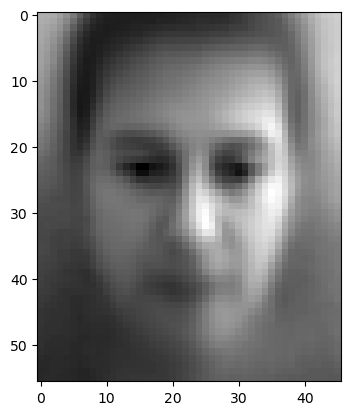

In [19]:
img = np.reshape(x_test_reconstructed[:, 0],(46,56)).T
plt.imshow(img, cmap = 'gist_gray')

**PCA-LDA based face recognition with the NN classifier**

In [39]:
class LDA:
    def __init__(self, M_pca=60, M_lda=30):
        self.M_pca = M_pca
        self.M_lda = M_lda
    
    def fit(self, x_train, y_train):
        # PCA
        self.pca = PCA(n_components=self.M_pca)  # Retain 95% of the variance
        x_train_pca = self.pca.fit_transform(x_train.T).T
        self.W_pca = self.pca.components_.T #(2576, M_pca)

        #LDA
        self.lda = LinearDiscriminantAnalysis(n_components=self.M_lda)  # Set components as needed
        x_train_proj = self.lda.fit_transform(x_train_pca.T, y_train.reshape(-1,)).T
        self.W_lda = self.lda.scalings_[:, :self.M_lda] #(M_pca, M_lda)
        
        self.W_opt = np.matmul(self.W_pca, self.W_lda) #(2576, M_lda)
        
        # PCA-LDA
        self.W_opt = self.W_pca @ self.W_lda

        # training NN classifier
        self.clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
        self.clf.fit(x_train_proj.T, y_train.ravel())

    def predict(self, x_test):
        # PCA-LDA
        x_test_pca = self.pca.transform(x_test.T).T
        x_test_proj = self.lda.transform(x_test_pca.T).T
        
        # prediction
        self.predictions = self.clf.predict(x_test_proj.T)
    
    def evaluate(self, y_test):
        # recognition accuracy
        accuracy = accuracy_score(y_test.ravel(), self.predictions)        
        return accuracy
    
    def confusion(self, y_test):
        cm = confusion_matrix(y_test.ravel(), self.predictions)
        # Confusion matrix 시각화
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()
        
    def reconstruction(self, x_test, plot=False, indices=[0, 1, 2]):
        # projection
        x_test_pca = self.pca.transform(x_test.T).T
        x_test_proj = self.lda.transform(x_test_pca.T).T
        # reconstruction
        x_test_rec = (self.W_lda @ x_test_proj) + np.mean(self.lda.means_, axis=0).reshape(-1, 1)
        x_test_rec = self.pca.inverse_transform(x_test_rec.T).T
        
        # MSE
        rec_err = np.mean((x_test - x_test_rec) ** 2)
        
        # plot reconstructed images
        if plot==True:
            # indices length >= 2
            plt.figure()
            f, ax = plt.subplots(1, len(indices))
            for i, idx in enumerate(indices):
                img = np.reshape(x_test_rec[:,idx],(46,56)).T
                ax[i].imshow(img, cmap = 'gist_gray')
                
        return rec_err

In [21]:
M_pca_ = [10, 30, 51, 100, 200, 364] # <= N-c = 416-52= 364
M_lda_ = [5, 10, 20, 30, 40, 51] # <= c-1 = 52-1 = 51
acc_results_lda = []

for M_pca in M_pca_:
    for M_lda in M_lda_:
        if M_pca >= M_lda:
            lda = LDA(M_pca=M_pca, M_lda=M_lda)
            lda.fit(x_train, y_train)
            lda.predict(x_test)
            # Calculate Accuracy
            accuracy = lda.evaluate(y_test)
            print(f"M_pca: {M_pca}, M_lda: {M_lda}, Accuracy: {accuracy * 100:.2f}%")
            acc_results_lda.append([M_pca, M_lda, accuracy])
            
acc_results_lda = np.array(acc_results_lda).T

M_pca: 10, M_lda: 5, Accuracy: 48.08%
M_pca: 10, M_lda: 10, Accuracy: 54.81%
M_pca: 30, M_lda: 5, Accuracy: 52.88%
M_pca: 30, M_lda: 10, Accuracy: 66.35%
M_pca: 30, M_lda: 20, Accuracy: 72.12%
M_pca: 30, M_lda: 30, Accuracy: 70.19%
M_pca: 51, M_lda: 5, Accuracy: 51.92%
M_pca: 51, M_lda: 10, Accuracy: 78.85%
M_pca: 51, M_lda: 20, Accuracy: 81.73%
M_pca: 51, M_lda: 30, Accuracy: 78.85%
M_pca: 51, M_lda: 40, Accuracy: 75.96%
M_pca: 51, M_lda: 51, Accuracy: 76.92%
M_pca: 100, M_lda: 5, Accuracy: 54.81%
M_pca: 100, M_lda: 10, Accuracy: 76.92%
M_pca: 100, M_lda: 20, Accuracy: 83.65%
M_pca: 100, M_lda: 30, Accuracy: 80.77%
M_pca: 100, M_lda: 40, Accuracy: 82.69%
M_pca: 100, M_lda: 51, Accuracy: 78.85%
M_pca: 200, M_lda: 5, Accuracy: 40.38%
M_pca: 200, M_lda: 10, Accuracy: 75.00%
M_pca: 200, M_lda: 20, Accuracy: 78.85%
M_pca: 200, M_lda: 30, Accuracy: 75.00%
M_pca: 200, M_lda: 40, Accuracy: 84.62%
M_pca: 200, M_lda: 51, Accuracy: 84.62%
M_pca: 364, M_lda: 5, Accuracy: 19.23%
M_pca: 364, M_lda:

C:\Users\user\AppData\Local\Temp\ipykernel_1488\26166776.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  heatmap_data = df.pivot("M_pca", "M_lda", "Accuracy")


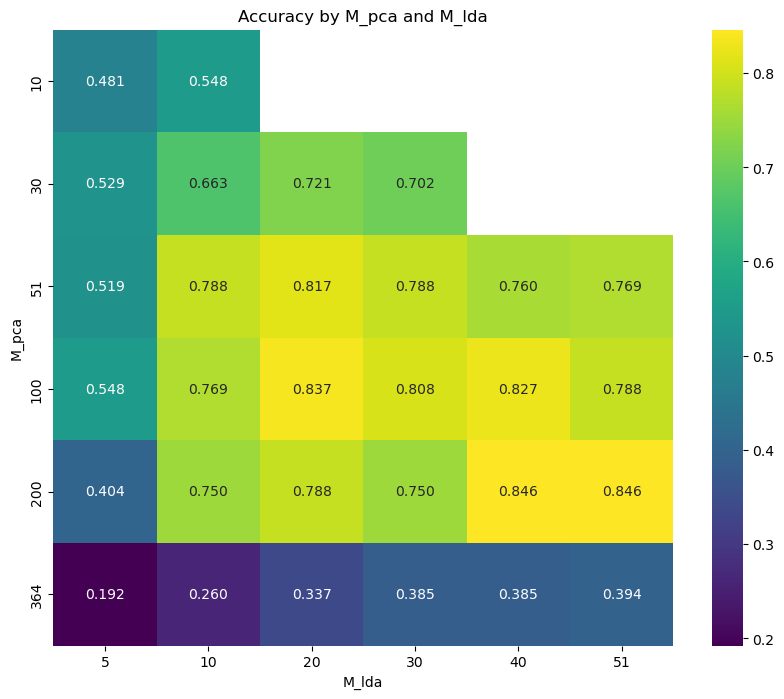

In [22]:
# M_pca, M_lda에 따른 recognition accuracy
df = pd.DataFrame({
    'M_pca': acc_results_lda[0].astype(int),
    'M_lda': acc_results_lda[1].astype(int),
    'Accuracy': acc_results_lda[2]
})
heatmap_data = df.pivot("M_pca", "M_lda", "Accuracy")

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".3f")
plt.title("Accuracy by M_pca and M_lda")
plt.show()

In [ ]:
M_pca_ = [50, 100, 200, 300] # <= N-c = 416-52= 364
M_lda_ = np.linspace(5, 50, 10, dtype=int) # <= c-1 = 52-1 = 51
err_results = []
acc_results = []

for M_pca in M_pca_:
    errors = []
    accuracies = []
    for M_lda in M_lda_:
        lda = LDA(M_pca=M_pca, M_lda=M_lda)
        lda.fit(x_train, y_train)
        
        # Reconstruction error
        error = lda.reconstruction(x_test)
        errors.append(error)
        
        # Recognition accuracy
        lda.predict(x_test)
        accuracy = lda.evaluate(y_test)
        accuracies.append(accuracy)
        
        print(f"M_pca: {M_pca}, M_lda: {M_lda}, Accuracy: {accuracy * 100:.2f}%, Rec. Error: {error}")
    err_results.append(errors)
    acc_results.append(accuracies)

M_pca: 50, M_lda: 5, Accuracy: 50.96%, Rec. Error: 1701.2141116881673
M_pca: 50, M_lda: 10, Accuracy: 81.73%, Rec. Error: 1701.2060987691914
M_pca: 50, M_lda: 15, Accuracy: 77.88%, Rec. Error: 1701.2003835540395
M_pca: 50, M_lda: 20, Accuracy: 80.77%, Rec. Error: 1701.19593384648
M_pca: 50, M_lda: 25, Accuracy: 83.65%, Rec. Error: 1701.1916392299916
M_pca: 50, M_lda: 30, Accuracy: 80.77%, Rec. Error: 1701.1880185273833
M_pca: 50, M_lda: 35, Accuracy: 78.85%, Rec. Error: 1701.1847253819942
M_pca: 50, M_lda: 40, Accuracy: 76.92%, Rec. Error: 1701.181989676392
M_pca: 50, M_lda: 45, Accuracy: 76.92%, Rec. Error: 1701.178910503052
M_pca: 50, M_lda: 50, Accuracy: 76.92%, Rec. Error: 1701.1748483457252
M_pca: 100, M_lda: 5, Accuracy: 58.65%, Rec. Error: 1701.205671598332
M_pca: 100, M_lda: 10, Accuracy: 73.08%, Rec. Error: 1701.1936563017432
M_pca: 100, M_lda: 15, Accuracy: 82.69%, Rec. Error: 1701.1831594617086
M_pca: 100, M_lda: 20, Accuracy: 80.77%, Rec. Error: 1701.1776841978253
M_pca: 10

In [65]:
# Reconstruction error of the overall mean image
overall_mean = np.mean(x_train, axis=1).reshape(-1,1) #(2576, 1)
error_mean = np.mean((x_test - overall_mean) ** 2)
errors_mean = np.stack([error_mean] * len(M_lda_))

# Recognition accuracy of the original dataset
clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
clf.fit(x_train.T, y_train.ravel())
predictions = clf.predict(x_test.T)
accuracy = accuracy_score(y_test.ravel(), predictions)
accuracy_original = np.stack([accuracy] * len(M_lda_))

In [78]:
# Reconstruction errors and REcognition accuracies using only PCA
accuracies_pca = []
errors_pca = []

for M_pca in M_lda_:
    pca = PCA(n_components=M_pca)
    x_train_pca = pca.fit_transform(x_train.T).T
    clf = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
    clf.fit(x_train_pca.T, y_train.ravel())
    
    x_test_pca = pca.transform(x_test.T).T
    predictions = clf.predict(x_test_pca.T)
    accuracy = accuracy_score(y_test.ravel(), predictions)        
    accuracies_pca.append(accuracy)
    
    x_test_rec = pca.inverse_transform(x_test_pca.T).T
    error = np.mean((x_test - x_test_rec) ** 2)
    errors_pca.append(error)
      
    print(f"M_pca: {M_pca}, Accuracy: {accuracy * 100:.2f}%, Rec. Error: {error}")

M_pca: 5, Accuracy: 39.42%, Rec. Error: 820.5999200992304
M_pca: 10, Accuracy: 46.15%, Rec. Error: 605.356477795876
M_pca: 15, Accuracy: 49.04%, Rec. Error: 527.1939059436834
M_pca: 20, Accuracy: 56.73%, Rec. Error: 458.1701524440585
M_pca: 25, Accuracy: 58.65%, Rec. Error: 416.05084561003196
M_pca: 30, Accuracy: 63.46%, Rec. Error: 383.79519621967825
M_pca: 35, Accuracy: 64.42%, Rec. Error: 360.7777957844672
M_pca: 40, Accuracy: 63.46%, Rec. Error: 339.4329586639785
M_pca: 45, Accuracy: 65.38%, Rec. Error: 323.42450125324416
M_pca: 50, Accuracy: 62.50%, Rec. Error: 307.6546306643612


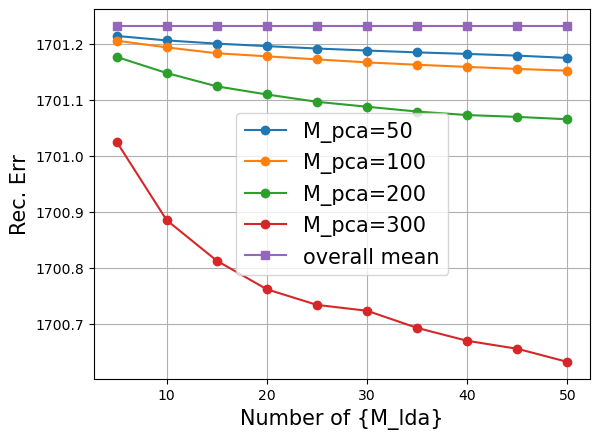

In [79]:
# Plot of Reconstruction errors

for i, M_pca in enumerate(M_pca_):
    plt.plot(M_lda_, err_results[i], label=f'M_pca={M_pca}', marker='o')
plt.plot(M_lda_, errors_mean, label='overall mean', marker='s')
#plt.plot(M_lda_, errors_pca, label='only PCA', marker='o')
plt.xlabel('Number of {M_lda}', fontsize=15)
plt.ylabel('Rec. Err', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

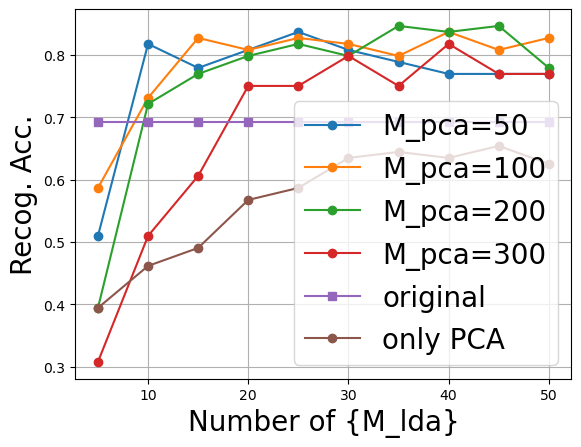

In [ ]:
# Plot of Reconstruction errors

for i, M_pca in enumerate(M_pca_):
    plt.plot(M_lda_, acc_results[i], label=f'M_pca={M_pca}', marker='o')
plt.plot(M_lda_, accuracy_original, label='original', marker='s')
plt.plot(M_lda_, accuracies_pca, label='only PCA', marker='o')
plt.xlabel('Number of {M_lda}', fontsize=15)
plt.ylabel('Recog. Acc.', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

**Ensemble Learning**

randomisation in feature space 

M0 개의 largest eigenvector<br/>
M1 개의 random eigenvector (nonzero)

In [ ]:
class LDA_random_feature(LDA):
    def __init__(self, M0=30, M1=30, M_lda=30, t=4, k=1, fusion='sum'):
        self.M0 = M0
        self.M1 = M1
        self.M_lda = M_lda
        self.t = t
        self.k = k
        self.fusion = fusion
        self.W_opts = []
        self.clfs = []

    
    def fit(self, x_train, y_train):
        St, Sw, Sb = super().scatter_matrix_calculation(x_train, y_train)

        # PCA
        eigvals, eigvecs = np.linalg.eigh(St)
        nonzero = eigvals>=0.00001
        eigvals = eigvals[nonzero]
        eigvecs = eigvecs[:, nonzero]
        sorted_indices = np.argsort(eigvals)[::-1]
        
        # random feature selection & LDA
        for t in range(self.t):
            indices = np.concatenate((sorted_indices[:self.M0], np.random.choice(sorted_indices[self.M0:], self.M1, replace=False)))
            W_pca = eigvecs[:, indices] #(2576, M0+M1)
            # LDA
            S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
            
            eigvals_lda, eigvecs_lda = np.linalg.eigh(S_lda)
            sorted_indices_lda = np.argsort(eigvals_lda)[::-1]
            eigvals_lda = eigvals_lda[sorted_indices_lda] #(M_pca,)
            eigvecs_lda = eigvecs_lda[:, sorted_indices_lda] #(M_pca, M_pca)
            W_lda = eigvecs_lda[:, :self.M_lda] #(M_pca, M_lda)
            W_opt = np.matmul(W_pca, W_lda) #(2576, M_lda)
            self.W_opts.append(W_opt)

        for t in range(self.t):
            clf = KNeighborsClassifier(n_neighbors=self.k, metric='manhattan')

            W_opt = self.W_opts[t]
            # projection of training images
            x_train_proj = np.matmul(W_opt.T, x_train - self.overall_mean)
            clf.fit(x_train_proj.T, y_train.reshape(-1))
            self.clfs.append(clf)
            
    def predict(self, x_test):
        x_test_proj = []
        for t in range(self.t):
            x_test_proj.append(np.matmul(self.W_opts[t].T, x_test - self.overall_mean))
        
        self.pred_indiv = np.array([clf.predict(x_test_proj[t].T) for t, clf in enumerate(self.clfs)])
        self.pred_proba = np.array([clf.predict_proba(x_test_proj[t].T) for t, clf in enumerate(self.clfs)])
        
        if self.fusion == 'majority':
            self.predictions = mode(self.pred_indiv, axis=0).mode[0]

        if self.fusion == 'sum':
            self.predictions = np.argmax(np.mean(self.pred_proba, axis=0), axis=1) + 1

        if self.fusion == 'product':
            epsilon = 1e-10
            log_probs = np.array([np.log(np.maximum(clf.predict_proba(x_test_proj[t].T), epsilon)) for t, clf in enumerate(self.clfs)])
            final_probs = np.exp(np.sum(log_probs, axis=0))
            final_probs /= final_probs.sum(axis=1, keepdims=True)
            self.predictions = np.argmax(final_probs, axis=1) + 1
        
        if self.fusion == 'all':
            self.predictions = []
            
            self.predictions.append(mode(self.pred_indiv, axis=0).mode[0])
            self.predictions.append(np.argmax(np.mean(self.pred_proba, axis=0), axis=1) + 1)
            epsilon = 1e-10
            log_probs = np.array([np.log(np.maximum(clf.predict_proba(x_test_proj[t].T), epsilon)) for t, clf in enumerate(self.clfs)])
            final_probs = np.exp(np.sum(log_probs, axis=0))
            final_probs /= final_probs.sum(axis=1, keepdims=True)
            self.predictions.append(np.argmax(final_probs, axis=1) + 1)

    def evaluate(self, y_test):
        # recognition accuracy
        acc_indiv = np.mean([accuracy_score(y_test.ravel(), self.pred_indiv[t]) for t in range(self.t)])
        accuracy = accuracy_score(y_test.ravel(), self.predictions)
        
        print(f"Individual Test Accuracy: {acc_indiv * 100:.2f}%")
        print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
        
        return acc_indiv, accuracy

In [15]:
M_list = [(int(i), int(60-i)) for i in np.linspace(0, 60, 7)]
acc_results_feat = []
acc_indiv_results_feat = []

for M0, M1 in M_list:
    lda_ensemble = LDA_random_feature(M0=M0, M1=M1)
    lda_ensemble.fit(x_train, y_train)
    lda_ensemble.predict(x_test)
    acc_indiv, acc = lda_ensemble.evaluate(y_test)
    acc_indiv_results_feat.append(acc_indiv)
    acc_results_feat.append(acc)

acc_results_feat

Individual Test Accuracy: 18.75%
Final Test Accuracy: 23.08%
Individual Test Accuracy: 48.56%
Final Test Accuracy: 50.96%
Individual Test Accuracy: 48.56%
Final Test Accuracy: 55.77%
Individual Test Accuracy: 53.12%
Final Test Accuracy: 56.73%
Individual Test Accuracy: 56.01%
Final Test Accuracy: 62.50%
Individual Test Accuracy: 52.88%
Final Test Accuracy: 56.73%
Individual Test Accuracy: 54.81%
Final Test Accuracy: 54.81%


[0.23076923076923078,
 0.5096153846153846,
 0.5576923076923077,
 0.5673076923076923,
 0.625,
 0.5673076923076923,
 0.5480769230769231]

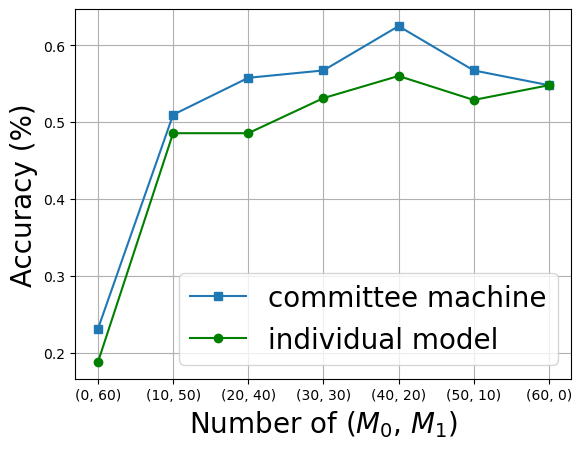

In [16]:
# accuracy over the number of eigenvectors
M_labels = [f"{pair}" for pair in M_list]

plt.plot(M_labels, acc_results_feat, label='committee machine', marker='s')
plt.plot(M_labels, acc_indiv_results_feat, label='individual model', marker='o', color='g')
plt.xlabel('Number of ($M_0$, $M_1$)', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)

In [47]:
lda_ensemble = LDA_random_feature(fusion='majority')
lda_ensemble.fit(x_train, y_train)
print(lda_ensemble.predict(x_test))
lda_ensemble.evaluate(y_test)

lda_ensemble = LDA_random_feature(fusion='sum')
lda_ensemble.fit(x_train, y_train)
print(lda_ensemble.predict(x_test))
lda_ensemble.evaluate(y_test)

lda_ensemble = LDA_random_feature(fusion='product')
lda_ensemble.fit(x_train, y_train)
print(lda_ensemble.predict(x_test))
lda_ensemble.evaluate(y_test)

C:\Users\user\AppData\Local\Temp\ipykernel_4148\2544949987.py:56: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.predictions = mode(preds, axis=0).mode[0]


None
Individual Test Accuracy: 50.24%
Final Test Accuracy: 56.73%
None
Individual Test Accuracy: 52.64%
Final Test Accuracy: 62.50%
None
Individual Test Accuracy: 55.05%
Final Test Accuracy: 64.42%


(0.5504807692307693, 0.6442307692307693)

Bagging<br/>
randomisation on data samples

데이터 쪼개고 나머진 안 건드려서 knn model 만들기

In [ ]:
class LDA_bagging(LDA):
    def __init__(self, M_pca=60, M_lda=30, n_dataset=4, n_samples=200, k=1, fusion='sum'):
        self.M_pca = M_pca
        self.M_lda = M_lda
        self.n_dataset = n_dataset
        self.n_samples = n_samples
        self.k = k
        self.fusion = fusion
        self.clfs = []
    
    def bagging(self, x_train, y_train):
        x_bagging = []
        y_bagging = []
    
        for t in range(self.n_dataset):
            sss = StratifiedShuffleSplit(n_splits=1, train_size=self.n_samples, random_state=t)
            # StratifiedShuffleSplit으로 샘플링
            for train_idx, _ in sss.split(x_train.T, y_train.T):
                x_resampled = x_train[:, train_idx]
                y_resampled = y_train[:, train_idx]
            x_bagging.append(x_resampled)
            y_bagging.append(y_resampled)
            
        x_bagging = np.array(x_bagging) #(n_dataset, 415, n_samples)
        y_bagging = np.array(y_bagging) #(n_dataset, 1, n_samples)
            
        return x_bagging, y_bagging
        
    def fit(self, x_train, y_train):
        St, Sw, Sb = super().scatter_matrix_calculation(x_train, y_train)

        # PCA
        eigvals, eigvecs = np.linalg.eigh(St)
        sorted_indices = np.argsort(eigvals)[::-1]
        eigvals = eigvals[sorted_indices] #(2576,)
        eigvecs = eigvecs[:, sorted_indices] #(2576, 2576)
        W_pca = eigvecs[:, :self.M_pca]
        
        # LDA
        S_lda = np.linalg.inv(W_pca.T @ Sw @ W_pca) @ (W_pca.T @ Sb @ W_pca)
        eigvals_lda, eigvecs_lda = np.linalg.eigh(S_lda)
        sorted_indices_lda = np.argsort(eigvals_lda)[::-1]
        eigvals_lda = eigvals_lda[sorted_indices_lda] #(M_pca,)
        eigvecs_lda = eigvecs_lda[:, sorted_indices_lda] #(M_pca, M_pca)
        W_lda = eigvecs_lda[:, :self.M_lda] #(M_pca, M_lda)
        self.W_opt = np.matmul(W_pca, W_lda)
        
        # bagging
        x_train_proj = np.matmul(self.W_opt.T, x_train - self.overall_mean)
        
        if self.n_samples == x_train.shape[1]:
            x_bagging = np.stack([x_train_proj] * self.n_dataset, axis=0)
            y_bagging = np.stack([y_train] * self.n_dataset, axis=0)
        else:
            x_bagging, y_bagging = self.bagging(x_train_proj, y_train)

        for t in range(self.n_dataset):
            clf = KNeighborsClassifier(n_neighbors=self.k, metric='manhattan')
            clf.fit(x_bagging[t].T, y_bagging[t].ravel())
            self.clfs.append(clf)
            
    def predict(self, x_test):
        x_test_proj = np.matmul(self.W_opt.T, x_test - self.overall_mean)
        
        # the predictions of individual models
        self.pred_indiv = np.array([clf.predict(x_test_proj.T) for clf in self.clfs])

        # the prediction of the committee machine with fusion rule
        if self.fusion == 'majority':
            preds = np.array([clf.predict(x_test_proj.T) for clf in self.clfs])
            self.predictions = mode(preds, axis=0).mode[0]

        if self.fusion == 'sum':
            preds = np.array([clf.predict_proba(x_test_proj.T) for clf in self.clfs])
            self.predictions = np.argmax(np.mean(preds, axis=0), axis=1) + 1

        if self.fusion == 'product':
            epsilon = 1e-10
            log_probs = np.array([np.log(np.maximum(clf.predict_proba(x_test_proj.T), epsilon)) for clf in self.clfs])
            final_probs = np.exp(np.sum(log_probs, axis=0))
            final_probs /= final_probs.sum(axis=1, keepdims=True)
            self.predictions = np.argmax(final_probs, axis=1) + 1

    def evaluate(self, y_test):
        # recognition accuracy
        acc_indiv = np.mean([accuracy_score(y_test.ravel(), self.pred_indiv[t]) for t in range(self.n_dataset)])
        accuracy = accuracy_score(y_test.ravel(), self.predictions)
        
        print(f"Individual Test Accuracy: {acc_indiv * 100:.2f}%")
        print(f"Final Test Accuracy: {accuracy * 100:.2f}%")
        
        return acc_indiv, accuracy

In [18]:
n_list = [52, 100, 200, 300, 350, 416]
acc_results = []
acc_indiv_results = []

for n in n_list:
    lda_ensemble = LDA_bagging(n_samples=n, n_dataset=10)
    lda_ensemble.fit(x_train, y_train)
    lda_ensemble.predict(x_test)
    acc_indiv, acc = lda_ensemble.evaluate(y_test)
    acc_indiv_results.append(acc_indiv)
    acc_results.append(acc)

acc_results

Individual Test Accuracy: 20.29%
Final Test Accuracy: 28.85%
Individual Test Accuracy: 29.04%
Final Test Accuracy: 48.08%
Individual Test Accuracy: 39.42%
Final Test Accuracy: 49.04%
Individual Test Accuracy: 47.50%
Final Test Accuracy: 53.85%
Individual Test Accuracy: 51.15%
Final Test Accuracy: 54.81%
Individual Test Accuracy: 54.81%
Final Test Accuracy: 54.81%


[0.28846153846153844,
 0.4807692307692308,
 0.49038461538461536,
 0.5384615384615384,
 0.5480769230769231,
 0.5480769230769231]

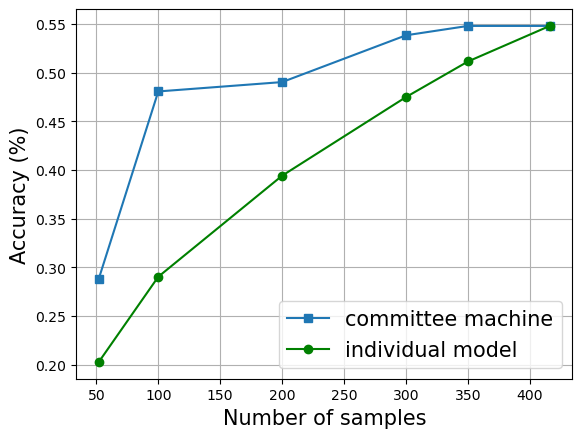

In [19]:
# accuracy over the number of data samples

plt.plot(n_list, acc_results, label='committee machine', marker='s')
plt.plot(n_list, acc_indiv_results, label='individual model', marker='o', color='g')
plt.xlabel('Number of samples', fontsize=15)
plt.ylabel('Accuracy (%)', fontsize=15)
plt.legend(fontsize=15)
plt.grid(True)

In [ ]:
n_models = np.linspace(10, 100, 10, dtype=int)
acc_major_results = []
acc_sum_results = []
acc_prod_results = []
acc_indiv_results = []

for n in n_models:
    lda_ensemble = LDA_random_feature(M0=40, M1=20, t=n, k=3, fusion='all')
    lda_ensemble.fit(x_train, y_train)
    lda_ensemble.predict(x_test)
    
    acc_indiv_results.append(np.mean([accuracy_score(y_test.ravel(), lda_ensemble.pred_indiv[t]) for t in range(n)]))
    acc_major_results.append(accuracy_score(y_test.ravel(), lda_ensemble.predictions[0]))
    acc_sum_results.append(accuracy_score(y_test.ravel(), lda_ensemble.predictions[1]))
    acc_prod_results.append(accuracy_score(y_test.ravel(), lda_ensemble.predictions[2]))

C:\Users\user\AppData\Local\Temp\ipykernel_35612\1839256853.py:71: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  self.predictions.append(mode(self.pred_indiv, axis=0).mode[0])
C:\Users\user\AppData\Local\Temp\ipykernel_35612\1839256853.py:71: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False 

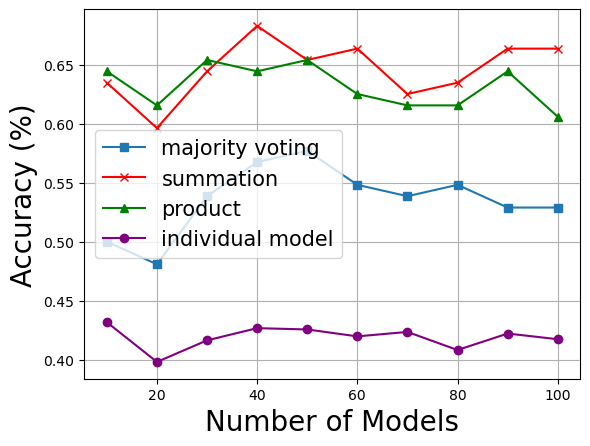

In [13]:
# accuracy over the number of base models
plt.plot(n_models, acc_major_results, label='majority voting', marker='s')
plt.plot(n_models, acc_sum_results, label='summation', marker='x', color='r')
plt.plot(n_models, acc_prod_results, label='product', marker='^', color='g')
plt.plot(n_models, acc_indiv_results, label='individual model', marker='o', color='purple')
plt.xlabel('Number of Models', fontsize=20)
plt.ylabel('Accuracy (%)', fontsize=20)
plt.legend(fontsize=15)
plt.grid(True)